In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl

In [2]:
def basis_transform(a: List, basis_function: str = 'sigmoid') -> pd.DataFrame:
    match basis_function:
        case 'sigmoid':
            for i in range(len(a)):
                a[i] = 1/(1+np.exp(-a[i]))
        case 'tanh':
            for i in range(len(a)):
                a[i] = np.tanh(a[i])    
    return a

In [3]:
# __init__
inputs = 7
M = 8
outputs = 2

basis_function = 'sigmoid'

# Initial weigths
w1 = []
for i in range(M):
    w1.append(np.ones(inputs+1))

w2 = []
for i in range(outputs):
    w2.append(np.ones(M+1))

def predict_sl(X, w_g, basis_function = 'sigmoid'):
    X_mod = utl.add_bias_column(X)
    X_np = X_mod.to_numpy()

    a = []
    for i in range(len(w_g)):
        a.append((w_g[i]*X_np).sum(axis=1))

    a = basis_transform(a, basis_function= basis_function)    
    return pd.DataFrame(np.array(a).T)

def predict(X):
    h = predict_sl(X, w1, basis_function= basis_function)
    z = predict_sl(h, w2, basis_function= basis_function)
    return z

C:\Users\an2fe\AppData\Local\Temp\ipykernel_18868\3274753860.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = utl.min_max_scaling(X[c])[0]
C:\Users\an2fe\AppData\Local\Temp\ipykernel_18868\3274753860.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c] = utl.min_max_scaling(y[c])[0]


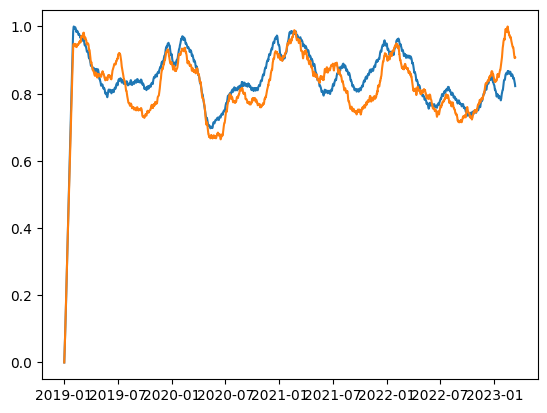

In [4]:
df = pd.read_csv('../data/1.raw/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'],index_col=['DateTime'])
X_cols = ['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
y_col = ['Consumption', 'Production']

df = df.rolling('30d').sum()

X = df[X_cols]
for c in X.columns:
    X[c] = utl.min_max_scaling(X[c])[0]

y = df[y_col]
for c in y.columns:
    y[c] = utl.min_max_scaling(y[c])[0]

plt.plot(y)

In [5]:
X.shape

(36772, 7)

In [6]:
h = predict_sl(X, w1, basis_function= basis_function)
z = predict_sl(h, w2, basis_function= basis_function)

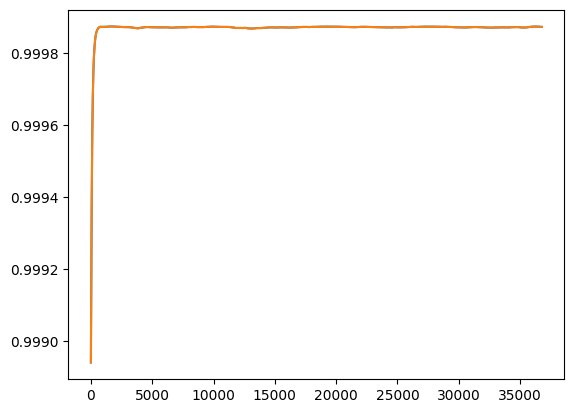

In [7]:
plt.plot(z)

In [8]:
h

,0,1,2,3,4,5,6,7
0,0.731059,0.731059,0.731059,0.731059,0.731059,0.731059,0.731059,0.731059
1,0.731987,0.731987,0.731987,0.731987,0.731987,0.731987,0.731987,0.731987
2,0.732918,0.732918,0.732918,0.732918,0.732918,0.732918,0.732918,0.732918
3,0.733843,0.733843,0.733843,0.733843,0.733843,0.733843,0.733843,0.733843
4,0.734743,0.734743,0.734743,0.734743,0.734743,0.734743,0.734743,0.734743
...,...,...,...,...,...,...,...,...
36767,0.997148,0.997148,0.997148,0.997148,0.997148,0.997148,0.997148,0.997148
36768,0.997145,0.997145,0.997145,0.997145,0.997145,0.997145,0.997145,0.997145
36769,0.997142,0.997142,0.997142,0.997142,0.997142,0.997142,0.997142,0.997142
36770,0.997139,0.997139,0.997139,0.997139,0.997139,0.997139,0.997139,0.997139
